   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  I

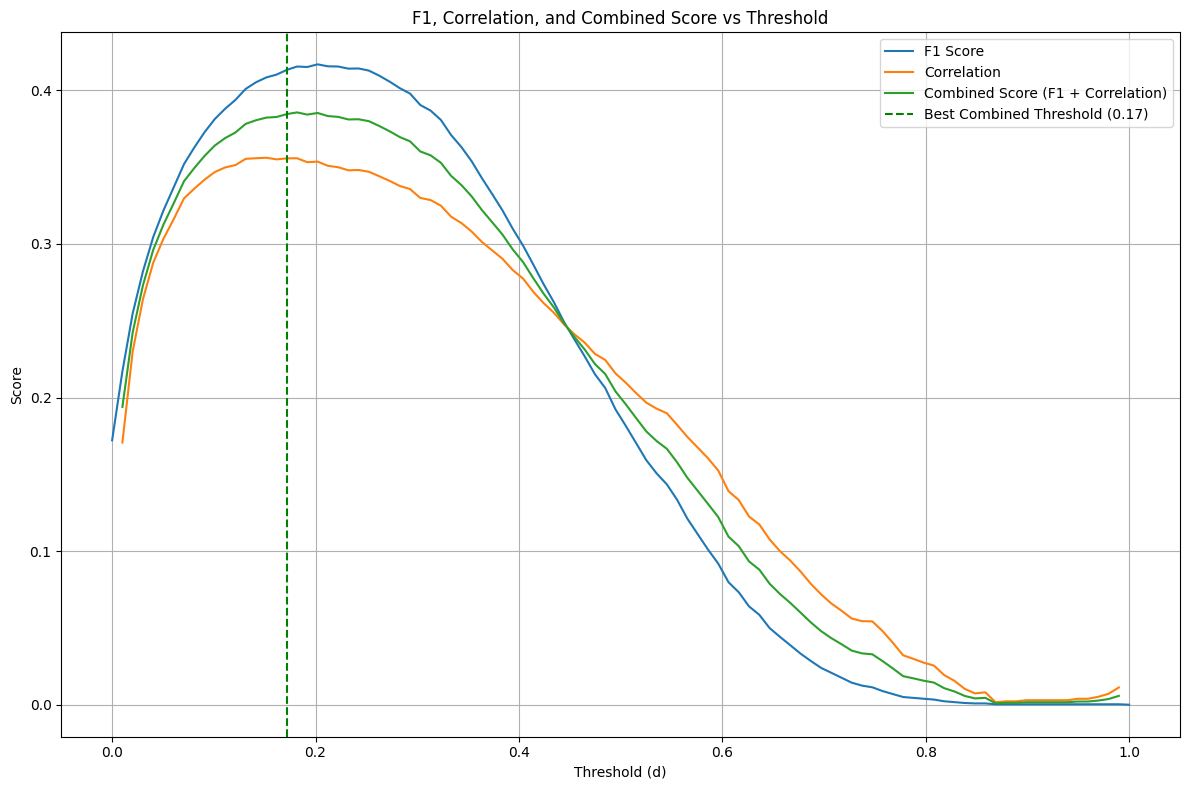


Confusion Matrix:
[[59094  9842]
 [ 2737  4431]]

Classification Report (Threshold = Best Combined):
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.90     68936
         1.0       0.31      0.62      0.41      7168

    accuracy                           0.83     76104
   macro avg       0.63      0.74      0.66     76104
weighted avg       0.89      0.83      0.86     76104


Final Metrics (Threshold = Best Combined):
Accuracy: 0.8347
Precision: 0.3104
Recall: 0.6182
F1 Score: 0.4133
Correlation: 0.3557
ROC-AUC Score: 0.8467

Model saved as '10.013-best_gbm_model.pkl'


In [1]:
# In this database, we have collected information about heart health as a function of several variables.
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
import joblib

# Load heart disease dataset
url = "https://raw.githubusercontent.com/btenneson/public_projects/refs/heads/main/predator/heart_disease_health_indicators_BRFSS2015.csv"
data = pd.read_csv(url)
print(data.head())

# Save a local copy
filename = "10.013.heart_disease_health_indicators_BRFSS2015.csv"
data.to_csv(filename, index=False)
print(f"File downloaded and saved as '{filename}'")

# Split features and target
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

# Show class distribution
print("\nTarget class distribution:")
print(y.value_counts(normalize=True))

# Train-test split (70% train, 30% test), stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize model
gb_model = GradientBoostingClassifier(random_state=42)

# Define grid
param_grid = {
    'n_estimators': [30],
    'max_depth': [3],
    'learning_rate': [1],
    'subsample': [0.7]
}

# CV
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)

# Train model
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='f1',
    refit=True,
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_params = grid_search.best_params_
print("\nBest parameters found:", best_params)

# Best model
best_model = grid_search.best_estimator_

# Predict probabilities
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Threshold sweep to optimize combined F1 and Correlation
thresholds = np.linspace(0, 1, 100)
f1_scores = []
correlations = []
combined_scores = []

alpha = 0.5  # Balance factor, can be adjusted

for d in thresholds:
    y_pred = (y_pred_proba >= d).astype(int)
    f1 = f1_score(y_test, y_pred)
    
    # Handle NaN correlation explicitly
    if np.std(y_pred) == 0 or np.std(y_test) == 0:
        corr = np.nan  # Force NaN if no variance
    else:
        corr = np.corrcoef(y_pred, y_test)[0, 1]
    
    # Set combined score to NaN if correlation is NaN
    if np.isnan(corr):
        combined_score = np.nan
    else:
        combined_score = alpha * f1 + (1 - alpha) * corr
    
    f1_scores.append(f1)
    correlations.append(corr)
    combined_scores.append(combined_score)

# Find best threshold, ignoring NaNs
valid_combined_scores = np.array(combined_scores)
valid_indices = ~np.isnan(valid_combined_scores)
best_d_combined = thresholds[np.argmax(valid_combined_scores[valid_indices])]

# Print the optimal threshold and combined score
print(f"\nOptimal threshold for combined F1 and Correlation: {best_d_combined:.4f} (Combined Score = {np.nanmax(valid_combined_scores):.4f})")

# Plot F1, Correlation, and Combined Score vs threshold
plt.figure(figsize=(12, 8))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, correlations, label='Correlation')
plt.plot(thresholds, combined_scores, label='Combined Score (F1 + Correlation)')
plt.axvline(x=best_d_combined, color='green', linestyle='--', label=f'Best Combined Threshold ({best_d_combined:.2f})')
plt.xlabel("Threshold (d)")
plt.ylabel("Score")
plt.title("F1, Correlation, and Combined Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Final prediction using best combined threshold
y_pred_final = (y_pred_proba >= best_d_combined).astype(int)

# Create a confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

# Classification report
print("\nClassification Report (Threshold = Best Combined):")
print(classification_report(y_test, y_pred_final))

# Final metrics
final_f1 = f1_score(y_test, y_pred_final)
final_corr = np.corrcoef(y_pred_final, y_test)[0, 1]
final_accuracy = accuracy_score(y_test, y_pred_final)
final_precision = precision_score(y_test, y_pred_final)
final_recall = recall_score(y_test, y_pred_final)
final_roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Metrics (Threshold = Best Combined):")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1:.4f}")
print(f"Correlation: {final_corr:.4f}")
print(f"ROC-AUC Score: {final_roc_auc:.4f}")

# Save model
joblib.dump(best_model, "10.013-best_gbm_model.pkl")
print("\nModel saved as '10.013-best_gbm_model.pkl'")
